<a href="https://colab.research.google.com/github/harish-babu/stash-melanoma-detection/blob/main/harish_babu_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
!wget https://harishbabu.in/Skin-Cancer-ISIC.zip

--2024-03-20 11:56:38--  https://harishbabu.in/Skin-Cancer-ISIC.zip
Resolving harishbabu.in (harishbabu.in)... 68.178.156.188
Connecting to harishbabu.in (harishbabu.in)|68.178.156.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824578245 (786M) [application/zip]
Saving to: ‘Skin-Cancer-ISIC.zip.1’

Skin-Cancer-ISIC.zi 100%[===================>] 786.38M  48.2MB/s    in 17s     

2024-03-20 11:56:55 (45.5 MB/s) - ‘Skin-Cancer-ISIC.zip.1’ saved [824578245/824578245]



In [ ]:
!unzip /content/Skin-Cancer-ISIC.zip.1

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount("/content/gdrive", force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
# Define a base path.  It can be changed when moving from colab to local
base_path = "/content/gdrive/MyDrive"     # This is for google drive
base_path = "/content"     # This is for google drive
# base_path = "."                         # This is for local
data_dir_train = pathlib.Path(base_path + "/Skin-Cancer-ISIC/Train")
data_dir_test = pathlib.Path(base_path + "/Skin-Cancer-ISIC/Test")

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Define some reusable functions

Define a function to display the training & validation accuracies

In [9]:
# Plot the training & validation accuracy
def plot_training_validation(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
# Training Data Set.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=42,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
# Validation Data Set.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=42,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
##### For every class take a sample and visualize the image


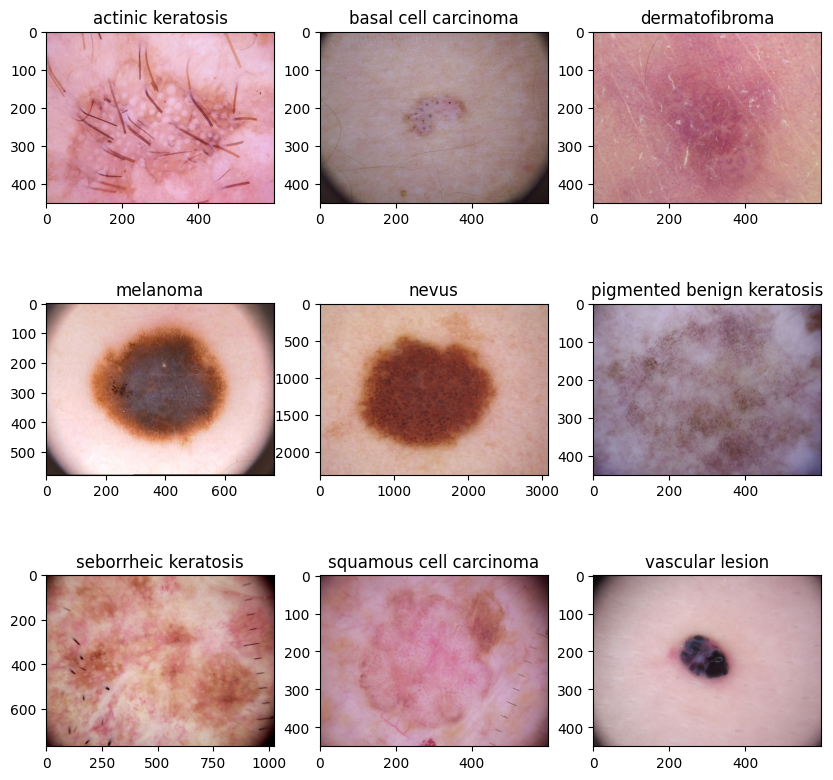

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Here is how we are creating the model

* Some pre-processing - Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`
* Multiple convolution & pooling layers

In [20]:
# Create a model.
# Model should rescale the pixels between [0,1] from the [0,255] in the input.
# The first layer does that
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [21]:
# Compile the model
# Use adam optimizer along with SparseCategoricalCrossentropy loss function
# Evaluate using accuracy as the metric
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [22]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Train the model

In [23]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
56/56 [==============================] - 7s 97ms/step - loss: 2.0709 - accuracy: 0.1869 - val_loss: 2.0244 - val_accuracy: 0.2081
Epoch 2/30
56/56 [==============================] - 5s 91ms/step - loss: 2.0295 - accuracy: 0.1814 - val_loss: 2.0171 - val_accuracy: 0.1723
Epoch 3/30
56/56 [==============================] - 5s 97ms/step - loss: 2.0124 - accuracy: 0.2171 - val_loss: 1.9586 - val_accuracy: 0.2617
Epoch 4/30
56/56 [==============================] - 5s 91ms/step - loss: 1.9087 - accuracy: 0.2863 - val_loss: 1.8693 - val_accuracy: 0.2685
Epoch 5/30
56/56 [==============================] - 5s 92ms/step - loss: 2.0796 - accuracy: 0.2165 - val_loss: 2.0777 - val_accuracy: 0.2394
Epoch 6/30
56/56 [==============================] - 5s 91ms/step - loss: 2.0154 - accuracy: 0.2171 - val_loss: 1.8878 - val_accuracy: 0.2796
Epoch 7/30
56/56 [==============================] - 5s 90ms/step - loss: 1.9501 - accuracy: 0.2690 - val_loss: 1.9071 - val_accuracy: 0.2953
Epoch 8/30
56

### Visualizing training results

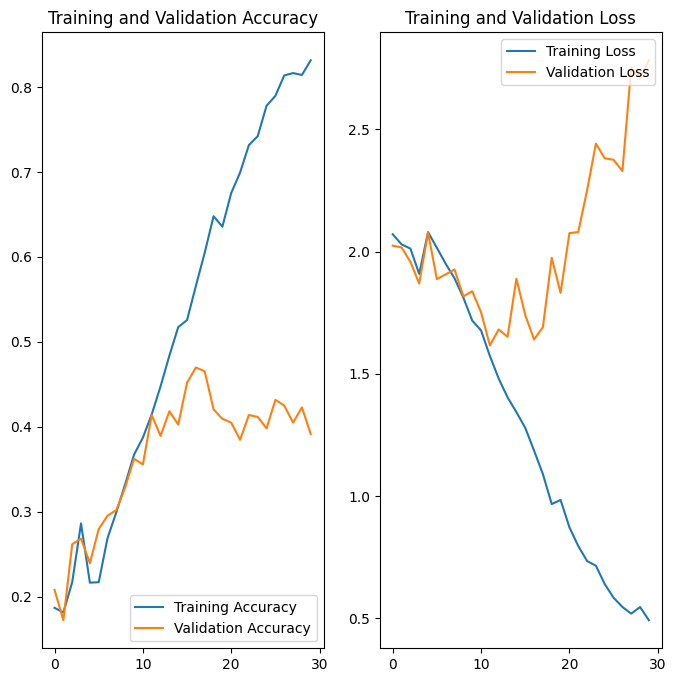

In [24]:
# Plot the validation & training accuracies
plot_training_validation(history, epochs)

#### Observations from First Model








- The model is overfitting because we can also see difference in loss functions in training & test around the 11 - 12th epoch

- The training accuracy is just over 80% because there are enough features to remember the pattern.

- But validation accuracy is very low.  This is a classic pattern of overfitting



In [25]:
# The first model shows overfitting pattern.
# We can use data augmentation to increase the number of training samples
# We can try with a few ways - rotation, zoom and flip.
data_augument = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical", input_shape=(img_height, img_width, 3)
        ),
        layers.experimental.preprocessing.RandomRotation(0.2, fill_mode="reflect"),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode="reflect"
        ),
    ]
)


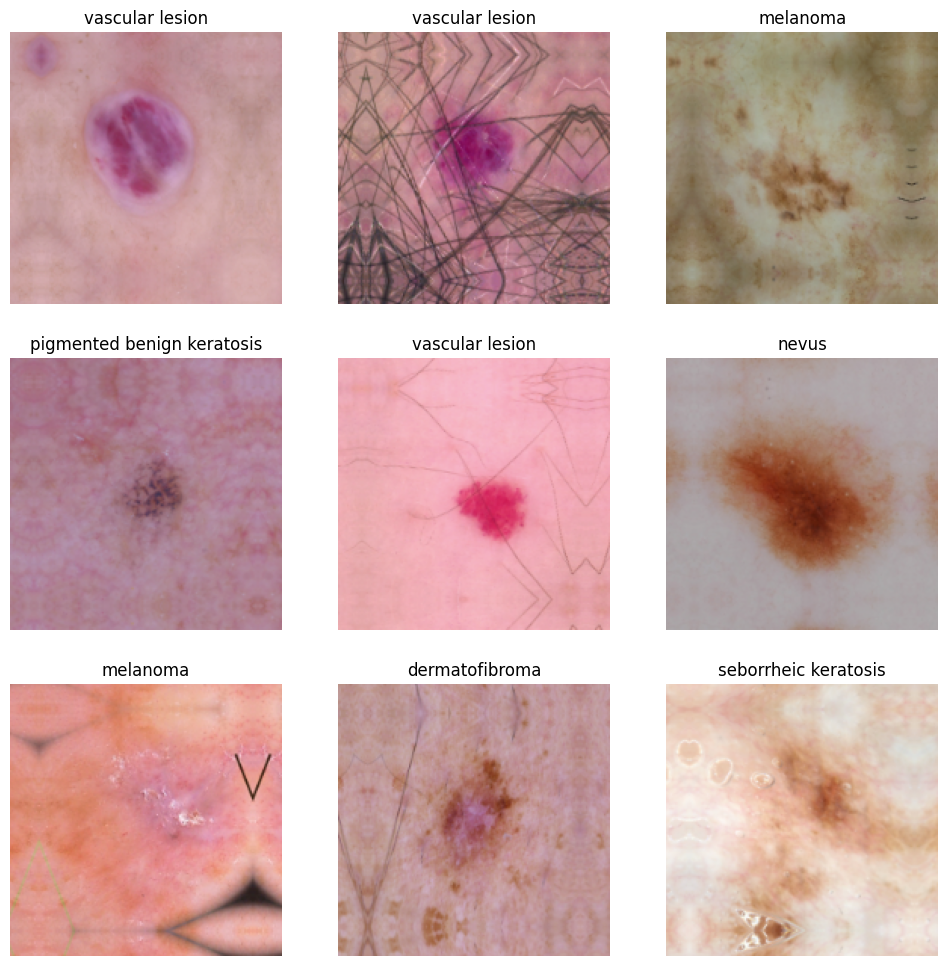

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
images, labels = next(iter(train_ds.take(1)))
for i, ax in enumerate(axs.flat):
    image = data_augument(images)[i].numpy().astype("uint8")
    label = class_names[labels[i]]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")


### Model Creation & Training with Augmented Data

#### Create a model using the augmented data & similar layers as earlier.

The difference between this model and previous models is the data that is used.  This uses the augmented data, whereas the earlier one used the original images.


In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [28]:
# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### Training the model

In [29]:
## Train the model for 30 epochs
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
56/56 [==============================] - 11s 116ms/step - loss: 2.0778 - accuracy: 0.1970 - val_loss: 2.0268 - val_accuracy: 0.2081
Epoch 2/30
56/56 [==============================] - 6s 105ms/step - loss: 2.0394 - accuracy: 0.2003 - val_loss: 2.0637 - val_accuracy: 0.2170
Epoch 3/30
56/56 [==============================] - 6s 104ms/step - loss: 2.0549 - accuracy: 0.1908 - val_loss: 2.0429 - val_accuracy: 0.1969
Epoch 4/30
56/56 [==============================] - 6s 110ms/step - loss: 2.0366 - accuracy: 0.1987 - val_loss: 2.0475 - val_accuracy: 0.1477
Epoch 5/30
56/56 [==============================] - 6s 103ms/step - loss: 2.0303 - accuracy: 0.1763 - val_loss: 2.0159 - val_accuracy: 0.2036
Epoch 6/30
56/56 [==============================] - 6s 103ms/step - loss: 2.0219 - accuracy: 0.2059 - val_loss: 2.0115 - val_accuracy: 0.2170
Epoch 7/30
56/56 [==============================] - 6s 104ms/step - loss: 2.0176 - accuracy: 0.2042 - val_loss: 2.0063 - val_accuracy: 0.2058
Epoch

### Visualizing the results

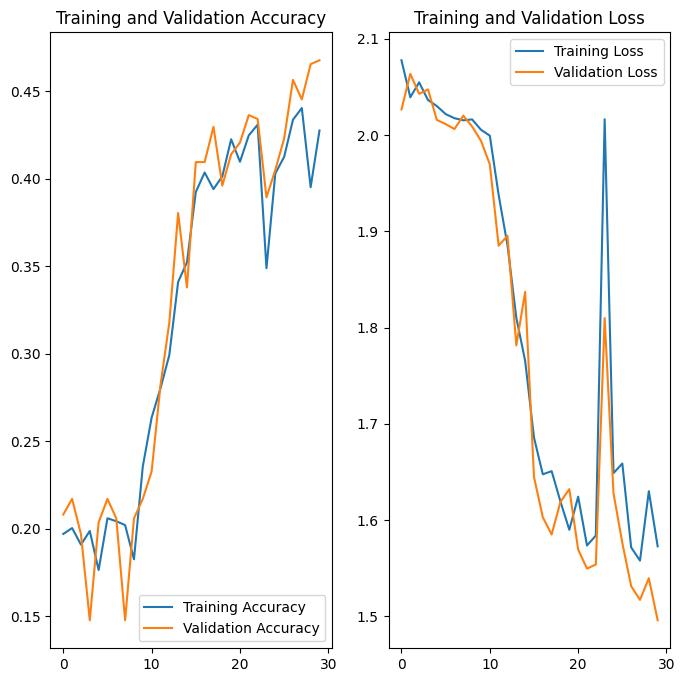

In [30]:
plot_training_validation(history, epochs)

**Finding from Second Model**

- There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

- We can increase the epochs to increase the accuracy so it's too early for judgement

### Correcting Class Imbalance
In numerous instances, datasets derived from real-world scenarios may exhibit class imbalance, where one class may have a significantly larger number of samples than the others. This imbalance can adversely impact the quality of the final model. Therefore, it’s crucial to perform a sanity check to understand the class distribution in the data.

In [31]:
data = [(str(j), i) for i in class_names for j in data_dir_train.glob(i + '/*.jpg')]
original_df = pd.DataFrame(data, columns=['Path', 'Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<BarContainer object of 9 artists>

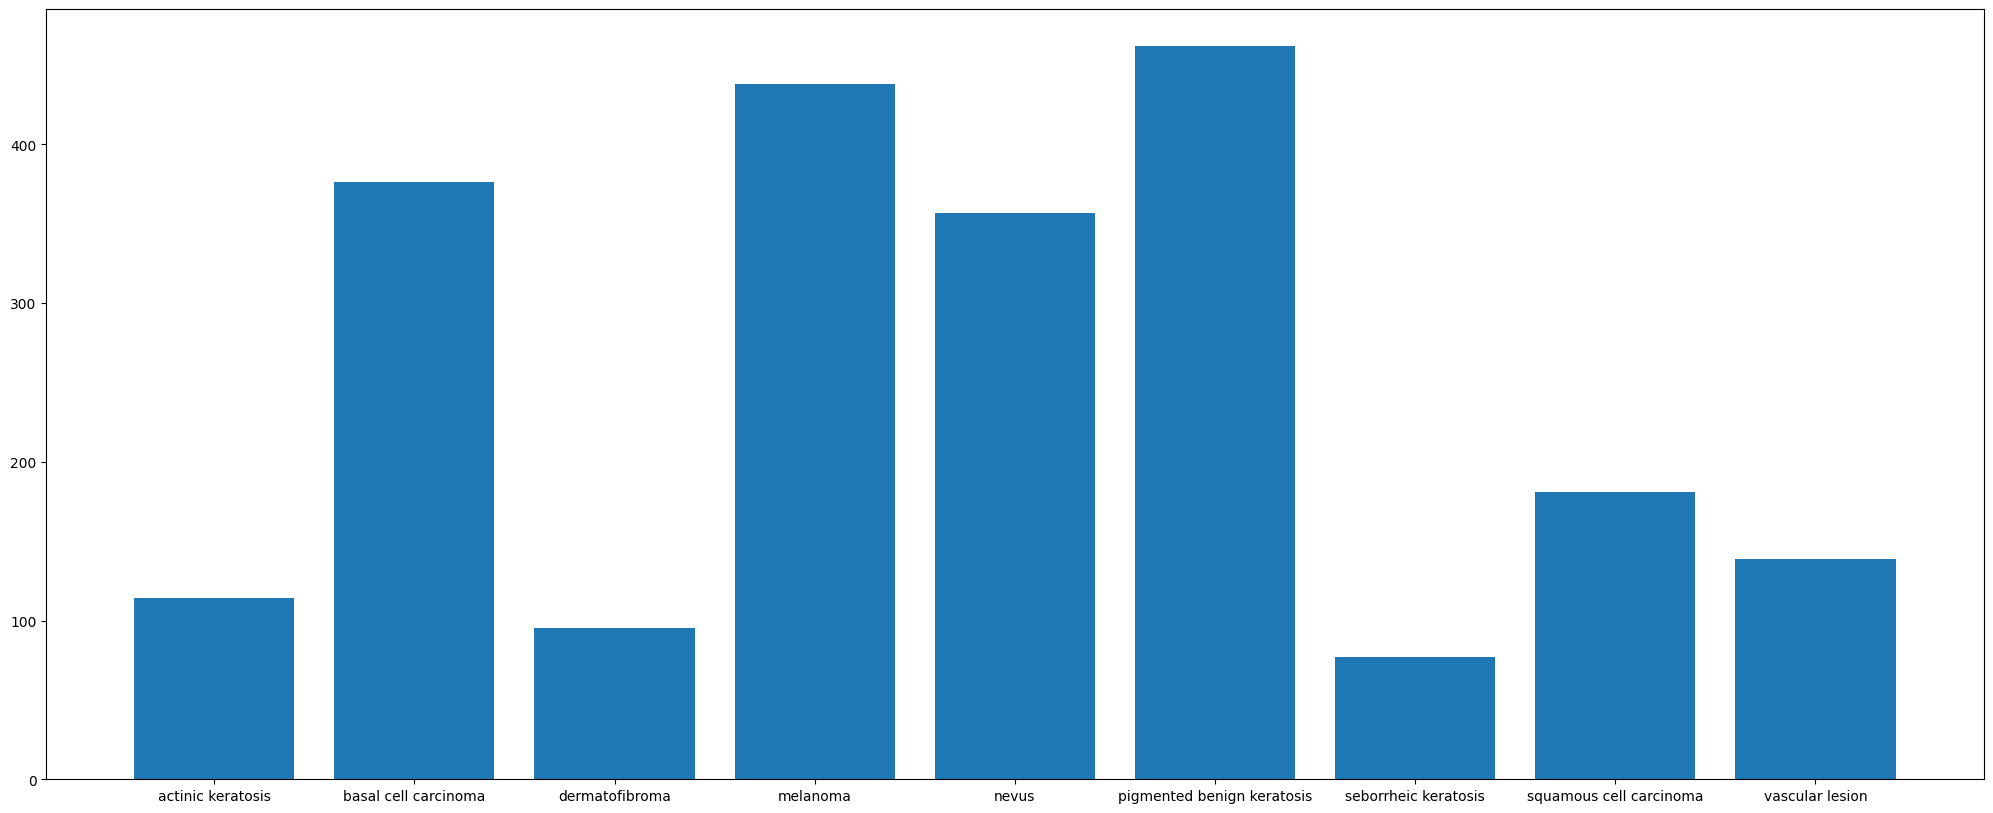

In [32]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Observations from analysis
- Which class has the least number of samples? Looks like seborrheic keratosis has least number of samples (77)
- Which classes dominate the data in terms proportionate number of samples? - **actinic keratosis and dermatofibroma** have proportionate number of classes . **melanoma and pigmented benign keratosis** have proprtionate number of classes


In [33]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Rectify the class imbalance
#### You can use a python package known as `Augmentor`. [Use this package](https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
path_to_training_dataset=base_path + "/Skin-Cancer-ISIC/Train/"
# After a bit of testing, it has been concluded that rotate alone is enough to
# augment data.  We don't need other methods like zoon or flip
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,save_format='jpg')
    p.rotate(probability=0.2, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)       # We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin-Cancer-ISIC/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E6AE40BF940>: 100%|██████████| 500/500 [00:09<00:00, 50.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin-Cancer-ISIC/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E6AE40522F0>: 100%|██████████| 500/500 [00:09<00:00, 50.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin-Cancer-ISIC/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E6AE40DB850>: 100%|██████████| 500/500 [00:10<00:00, 46.08 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin-Cancer-ISIC/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7E6B57733610>: 100%|██████████| 500/500 [00:46<00:00, 10.84 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin-Cancer-ISIC/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E6B406C03D0>: 100%|██████████| 500/500 [00:28<00:00, 17.86 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin-Cancer-ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E6AE41F92D0>: 100%|██████████| 500/500 [00:09<00:00, 51.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin-Cancer-ISIC/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E6AE40A12D0>: 100%|██████████| 500/500 [00:16<00:00, 31.02 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin-Cancer-ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E6AE1F1A560>: 100%|██████████| 500/500 [00:08<00:00, 57.60 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin-Cancer-ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6B40615240>: 100%|██████████| 500/500 [00:07<00:00, 63.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
data = [(str(j), i) for i in class_names for j in data_dir_train.glob(i + '/**/*.jpg')]
original_df = pd.DataFrame(data, columns=['Path', 'Label'])
original_df['Label'].value_counts()

# Print the DataFrame
print(original_df['Label'].value_counts())

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64





So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor
Now that we have added 500 images per class, let us train the model with the extended image set.

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
import pathlib
data_dir_train1=pathlib.Path(base_path + "/Skin-Cancer-ISIC/Train")

#### Train/Test Split

In [40]:
image_count_train1 = len(list(data_dir_train1.glob('**/*.jpg')))
print("Number of images to train with: ", image_count_train1)

Number of images to train with:  6739


In [41]:


# Train set
data_dir_train1 = pathlib.Path(base_path + "/Skin-Cancer-ISIC/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train1,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [42]:
# Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train1,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model Training with Dropout & Data Augmentation

In [43]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9
model = Sequential(
    [
        layers.experimental.preprocessing.Rescaling(
            1.0 / 255, input_shape=(img_height, img_width, 3)
        )
    ]
)
model.add(
    Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding="Same",
        activation="relu",
        input_shape=(180, 180, 32)
    )
)

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
# Add a dropout layer to prevent overfitting
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation="softmax"))

In [44]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


In [45]:
epochs=50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 34s 188ms/step - loss: 2.1811 - accuracy: 0.1584 - val_loss: 2.0374 - val_accuracy: 0.2324
Epoch 2/50
169/169 [==============================] - 31s 182ms/step - loss: 2.0600 - accuracy: 0.1892 - val_loss: 1.8393 - val_accuracy: 0.2442
Epoch 3/50
169/169 [==============================] - 30s 175ms/step - loss: 1.7749 - accuracy: 0.3162 - val_loss: 1.6608 - val_accuracy: 0.3638
Epoch 4/50
169/169 [==============================] - 30s 176ms/step - loss: 1.5486 - accuracy: 0.4186 - val_loss: 1.4502 - val_accuracy: 0.4684
Epoch 5/50
169/169 [==============================] - 30s 172ms/step - loss: 1.4548 - accuracy: 0.4570 - val_loss: 1.3917 - val_accuracy: 0.4699
Epoch 6/50
169/169 [==============================] - 29s 170ms/step - loss: 1.3366 - accuracy: 0.5106 - val_loss: 1.3461 - val_accuracy: 0.4878
Epoch 7/50
169/169 [==============================] - 31s 174ms/step - loss: 1.3030 - accuracy: 0.5237 - val_loss: 1.3162 - val_accuracy: 0.5

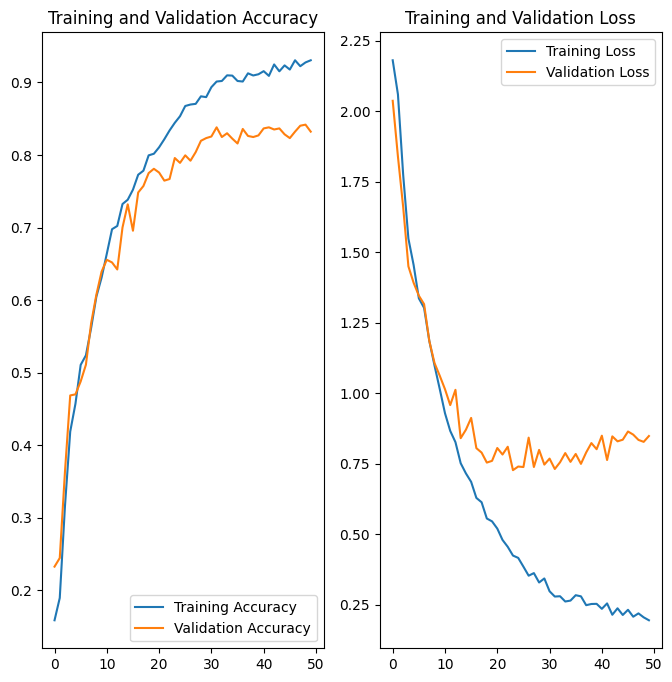

In [46]:
# Model accuracy visualization
plot_training_validation(history, epochs)

### Analysis of final model


- **Improved Accuracy with Augmentor Library**: The application of the Augmentor library for image augmentation has led to a significant improvement in the model's accuracy on the training data. By creating varied versions of existing images, the model has been exposed to a broader range of data, enhancing its ability to generalize and thus boosting its performance.
- **Overfitting Reduced**: The issue of overfitting, where the model performs well on the training data but poorly on unseen data, has been significantly reduced. This improvement is evident from the fact that the model's accuracy on the validation data is reasonably close to its accuracy on the training data.
- **Dropout Layer Effectiveness**: The addition of dropout layers to the neural network has proven effective in combating overfitting. Dropout layers work by randomly setting a fraction of input units to 0 during each update in the training phase, which helps in making the model less sensitive to specific weights of neurons, thereby improving its ability to generalize.
- **Training and Validation Loss**: Both the training and validation loss are decreasing, indicating that the model is learning from the training data and generalizing well to unseen data. The validation loss is decreasing at a slower rate than the training loss, which is expected as the model is not learning directly from the validation data.
- **Potential for Further Improvement**: Despite the improvements made, there is still potential for further enhancing the model's performance. This could be achieved through hyperparameter tuning, which involves adjusting parameters like the learning rate, batch size, number of layers, and number of neurons in each layer. By finding the optimal configuration for these parameters, the model's performance on both the training and validation data can be maximized.